乐云推荐算法之定义参与推荐字段及其权重的数据分析

## 任务需求

基于内容的推荐算法需要事先定义参与推荐计算的字段及其权重。推荐的方法是**和客户一起讨论从业务角度进行定义**。如果条件不许可的话，就只能从客户提供的成交数据中获取相关信息。因为每个企业关注的重点可能不同，并且提供的成交客户名单也不多（100个左右），可以把这100家企业的所有字段列出来，然后逐一观察每个字段的数据，通过各种方法寻找他们之间是否存在较大的关联性（共性），然后再结合人工判断，定义是否作为参与推荐计算的字段及其权重。

这里的数据分析主要是为人工判断提供依据，是否定义字段或者字段的权重还是需要结合业务进行人工判断。所以在下面的数据分析中，我们仅提供分析结论，具体是否作为参与推荐计算的字段以及其权重定义不在我们讨论范围内。因此定义字段及其权重的工作流程如下，**先由数据分析人员对数据进行分析，提供数据共性判断依据。然后业务人员和数据分析人员一起从业务角度和数据角度共同定义参与推荐计算的字段及其权重**。

我们在下面的以模拟数据为例演示了**数据分析人员对数据进行分析，提供数据共性判断依据**的详细过程，供数据分析人员参考。提供数据分析示例的用意不在于掌握具体的方法，而是介绍一种数据分析的思想，希望能够抛砖引玉，对大家分析数据提供一些帮助。

我们在下面的数据分析中，重点展示三类典型字段的分析：
- 列表字段
- 数字字段
- 文本字段

这三类字段基本涵盖了大部分的数据类型。

这里我们假设各字段是统计独立的，如果假设不成立则不能完全照搬演示的方法，可能会用到其他分析手段。这里我们关注的主要是一维数据，如果是二维或者多维度数据，也需要多维数据的分析方法。

该任务的输出是相似度字段定义及权重表，参见[推荐算法建模](https://shimo.im/sheet/3xjsKq62soYKJXZn/RIDOC)，作为推荐算法的输入。

In [1]:
%cd /home/david/dev/recommender/

/home/david/dev/recommender


In [299]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## 准备数据

本次演示的模拟数据如下：

为了进行对比，我们使用两个数据集进行对比实验，这两个数据集具有完全相同的字段。一个是乐云提供未成交客户，随机取100个，我们认为它代表了无共性的企业，作为反例；另一个是之前使用推荐算法推荐出来的企业，取得分最高的前100个，我们认为它代表了具有共性的企业，作为正例。

这两个数据共包含了12个字段，涵盖了3种典型的数据类型：
- 数字
- 列表
- 文字

下面我们从文件中载入数据。载入未成交数据：

In [43]:
nodeals_ = pd.read_csv('data/nodeal.csv', sep='|')
nodeals_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6609 entries, 0 to 6608
Data columns (total 12 columns):
chinese_name      6609 non-null object
company_status    6609 non-null object
industry_one      6609 non-null object
industry_two      6609 non-null object
company_type      6609 non-null object
products          6609 non-null object
regit_capital     6609 non-null float64
regit_date        6609 non-null object
city              6609 non-null object
avg_staff_num     6609 non-null int64
job_num           6609 non-null int64
description       6609 non-null object
dtypes: float64(1), int64(2), object(9)
memory usage: 619.7+ KB


In [69]:
nodeals = nodeals_.reindex(np.random.permutation(nodeals_.index))

In [83]:
nodeals = nodeals.iloc[:100]

载入推荐数据：

In [134]:
recommend_ = pd.read_csv('data/recommend.csv', sep='|')
recommend_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6609 entries, 0 to 6608
Data columns (total 13 columns):
chinese_name      6609 non-null object
company_status    6609 non-null object
industry_one      6609 non-null object
industry_two      6609 non-null object
company_type      6609 non-null object
products          6609 non-null object
regit_capital     6609 non-null float64
regit_date        6609 non-null object
city              6609 non-null object
avg_staff_num     6609 non-null int64
job_num           6609 non-null int64
description       6609 non-null object
score             6609 non-null float64
dtypes: float64(2), int64(2), object(9)
memory usage: 671.3+ KB


In [135]:
recommend = recommend_.iloc[:100]

下面我们分别对三种类型的数据进行分析。

## 列表类型

包括如下字段
- company_status 
- industry_one
- indsutry_two
- company_type
- city

这是最简单的一类，列取值为从固定大小的列表中取值，比如company_status取值`[存续，在业]`。通过观察每种类别出现的频次分布，可以得出结论。

下面的分析以city（城市）为例。其他字段类似，但是注意对于有关联的字段，例如industry_one（企业类型一级分类）、indsutry_two（企业类型二级分类），要根据实际业务需求进行分析。

### 对推荐数据的分析

首先查看数据整体统计情况

In [263]:
recommend.describe(include=[np.object])

,chinese_name,company_status,industry_one,industry_two,company_type,products,regit_date,city,description
count,100,100,100,100,100,100,100,100,100
unique,100,2,12,24,1,100,99,2,100
top,成都柚子科技有限公司,存续,科学研究和技术服务业,科技推广和应用服务业,内资企业,"计算机软硬件及配件的技术开发及销售 , 游戏研发及销售 , 通讯设备研发及销售 , 计算机系...",2015-12-16 00:00:00,成都市,重庆环球优雅商贸有限公司自成立以来主要从事股票，期货，现货等方面的金融服务工作，致力于为客户...
freq,1,98,31,28,100,1,2,74,1


从上表可知所在城市共有2类，出现最多的是`成都市`的企业，有74家。再观察每种类型出现的个数

In [266]:
recommend.city.value_counts()

成都市    74
重庆市    26
Name: city, dtype: int64

其中成都市企业有74家，重庆市企业有26家。

**结论:** 可知这100家企业城市分布在川渝地区，且以成都市为主。说明对于推荐数据的城市字段，共性较强，可以考虑定义为参与推荐计算的字段，并且定义较高的权重。

### 对未成交数据的分析

再看nodeal中的城市数据

In [267]:
nodeals.city.value_counts()

南京市      9
上海市      8
重庆市      8
杭州市      7
广州市      6
东莞市      4
成都市      3
南通市      3
无锡市      3
贵阳市      2
深圳市      2
郑州市      2
南充市      2
昆明市      2
青岛市      2
西安市      2
镇江市      1
宁波市      1
新余市      1
珠海市      1
南安市      1
玉溪市      1
泰兴市      1
常州市      1
邢台市      1
中山市      1
南宁市      1
济南市      1
淮安市      1
海口市      1
北安市      1
铜川市      1
福州市      1
天津市      1
大连市      1
宁德市      1
承德市      1
东台市      1
扬州市      1
德阳市      1
九江市      1
项城市      1
石家庄市     1
盐城市      1
张家口市     1
张家港市     1
温州市      1
邯郸市      1
五大连池市    1
辽阳市      1
台州市      1
Name: city, dtype: int64

从数据中可以看到城市分布较广，并且没有占据明显优势的城市。

**结论：**可见对于未成交数据来说，城市分布基本无共性，可以不作为参与推荐计算的字段，或者定义较低的权重。

##  数值类型

包括以下字段
- regist_captial 
- avg_staff_num
- job_num
- regit_date (时间类型需要先转换为数值类型)

对于数字字段的分析，思路如下：
1. 首先直接观察数据
2. 计算常用统计量并进行分析
3. 绘制直方图观察数据分布情况（二维数据可以绘制散点图）
4. 结合上述三点得出结论

下面分析以regit_capital（注册资本）为例进行分析，其他字段类似。

### 对推荐数据的分析

首先，直接观察数据

In [270]:
recommend.regit_capital

0        100.000
1        100.000
2        100.000
3        100.000
4         50.000
5        100.000
6         50.000
7        100.000
8         90.000
9        100.000
10        50.000
11        50.000
12        50.000
13       100.000
14         3.000
15        10.000
16        50.000
17        20.000
18        50.000
19        50.000
20        10.000
21       100.000
22       100.000
23       100.000
24        10.000
25       100.000
26       100.000
27       100.000
28       100.000
29      1000.000
         ...    
70        50.000
71       100.000
72       100.000
73        13.700
74        30.000
75       203.000
76       100.000
77    500000.000
78        10.000
79       100.000
80       200.000
81       100.000
82        30.000
83      1000.000
84       500.000
85       500.000
86       100.000
87        50.000
88       400.000
89         3.000
90       100.000
91        30.000
92       100.000
93      5000.000
94        30.000
95       200.000
96       100.000
97       204.2

直观上看这些数据大多分布在100左右，说明企业注册资金大多在100万左右，以中小企业为主。再来看常用的统计量：

In [268]:
recommend.describe(include=[np.number])

,regit_capital,avg_staff_num,job_num,score
count,1.000000e+02,100.000000,100.000000,100.000000
mean,1.052070e+05,42.950000,0.040000,29.855626
std,1.000723e+06,28.764588,0.281411,1.101437
min,3.000000e+00,1.000000,0.000000,28.502869
25%,5.000000e+01,20.000000,0.000000,29.003289
50%,1.000000e+02,50.000000,0.000000,29.522468
75%,1.400000e+02,50.000000,0.000000,30.409866
max,1.000000e+07,100.000000,2.000000,33.135529


在`regit_capital`列可以发现均值为1.052070e+05，标准差为1.000723e+06，感觉和上一步的观察不符合，均值非常大。进一步分析可发现这是因为存在异常值，从最大值为1.000000e+07也可以看出来，相当于1000亿的注册资金，不符合常理，一般不会有企业注册资金会有1000亿，可能是数据错误或者单位错误。因此我们可以剔除异常值再进行判断。取Q3分位数（表中75%的行对应的值，代表样本中75%的值小于该值，这样就剔除了异常大的值）140，考虑小于Q3的样本的统计量：

In [272]:
recommend.regit_capital[recommend.regit_capital < 140].describe()

count     75.000000
mean      67.662667
std       34.886487
min        3.000000
25%       50.000000
50%       50.000000
75%      100.000000
max      120.000000
Name: regit_capital, dtype: float64

可以看到小于Q3分位数的样本均值为67.66，标准差为34.89，比较接近我们在第一步观察数据得到的结论：企业注册资金在100万左右，以中小企业为主。

进一步绘制直方图直观观察数据分布：

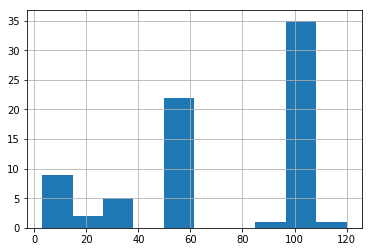

In [275]:
recommend.regit_capital[recommend.regit_capital < 140].hist()

从图中可以看到分布在100左右区间的样本数量最多，其次在50左右，余下在40以下。不过由于样本数量较小，从图中并不能看出明显的分布情况（例如正态分布、均匀分布等）。

**结论：** 结合上面三步的分析，对于recommend的注册资金regit_capital字段大部分分布在100左右，共性较强，可以考虑定义为参与推荐计算的字段，并且定义较高的权重。

### 对未成交数据的分析

同样按照上面的分析步骤，首先是观察数据：

In [276]:
nodeals.regit_capital

2705          10.0
4132          10.0
5151         100.0
4140        1000.0
436          200.0
3790          50.0
5713     1000000.0
6585          50.0
6257     3000000.0
2309         100.0
3658          20.0
423     20000000.0
5118         500.0
1846         200.0
4886         728.0
4326          50.0
4434         800.0
2791         500.0
3325         100.0
1415          50.0
710       500000.0
969         1100.0
1772     1000000.0
6160     2000000.0
5337         300.0
6521          50.0
2901         600.0
4799          50.0
6208          10.0
1738          50.0
           ...    
5063          50.0
4803         100.0
1397          81.0
3166           5.0
595           60.0
4746     5882350.0
1920        1000.0
4792          10.0
1007         200.0
393            1.0
6512         500.0
6403       20000.0
5241         500.0
6589         500.0
1096         500.0
539           50.0
563          100.0
4850          30.0
5466     2000000.0
6401         100.0
1690          50.0
1154        

直观上看这些数据，分布比较广，并无recommend数据中明显的分布特征。再来看常用统计量：

In [277]:
nodeals.describe()

,regit_capital,avg_staff_num,job_num
count,1.000000e+02,100.0000,100.00
mean,2.936080e+07,119.9600,0.01
std,2.842712e+08,554.4619,0.10
min,1.000000e+00,1.0000,0.00
25%,5.000000e+01,10.7500,0.00
50%,2.000000e+02,40.0000,0.00
75%,1.025000e+03,75.0000,0.00
max,2.843444e+09,5499.0000,1.00


考虑到存在异常值（最大值2.843444e+09，注册资金不可能到达这个数量级），我们仍然只考虑Q3分位数以下的样本：

In [278]:
nodeals.regit_capital[nodeals.regit_capital < 1025].describe()

count      75.000000
mean      217.414816
std       248.245534
min         1.000000
25%        50.000000
50%       100.000000
75%       500.000000
max      1000.000000
Name: regit_capital, dtype: float64

均值在271.41，标准差为248.25，对比上面的推荐数据，样本偏离均值较大，说明样本分布比较广，与第一步的观察结论一致。再来看一下绘制的直方图：

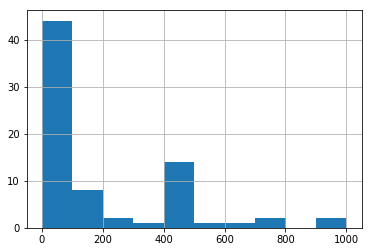

In [279]:
nodeals.regit_capital[nodeals.regit_capital < 1025].hist()

从图中可见样本在0~100的区间内数量最多，接近50%，其余在分布在100~1000内。从图中看不出明显的分布特征。

**结论：** 综合上面几步的分析来看，nodeals的注册资金接近50%低于100万，但是另外50%分布比较离散，样本共性不够明显。相对于recommend的样本特征，可以考虑不定义为参与推荐计算的字段，或者定义较低的权重。

### 思考

上面的分析过程是通过数据观察给出的定性结论，是否能从理论上定量给出评判标准？


## 文本类型

包括以下字段
- chinese_name
- products
- description

分析思路：<br>
对文本的处理，我们以产品信息字段为例。需要找到这100家企业产品信息的相似性，直觉上我们可以统计关键词出现的频度，出现频度高的关键词代表了这100家企业产品的共性。不过这一方法有一个问题，考虑极端情况，如果这100家企业中仅有一家企业的产品信息描述字段中出现了大量`汽车`关键词，则统计关键词频度的时候，`汽车`这个关键词的频度就会很高，导致我们会把`汽车`作为100家企业的共性，但实际上只有一家企业与汽车相关。因此不能直接统计关键词频度，而应该统计关键词在这100家企业产品信息中出现的频度（以下简称为文档频度），关键词的文档频度越高，说明这个关键词的共性越强。

为了比较直观的观察关键词的文档频度，我们绘制关键词的文档频度分布图，从图中进行观察分析。

### 对推荐数据的分析

文本类型的处理比较麻烦一些，需要对文本做一些处理以方便我们进行分析。

In [7]:
import jieba, re

def load_stopword_list(filepath):
    """
    载入停用词表。载入从网上找到的包含1893个停用词表。
    """
    
    stopwords = []
    with open(filepath, 'r', encoding='utf-8') as f:
        stopwords += [line.strip() for line in f.readlines()]
    return stopwords

def seg_sentence_rm_stopword(sentence, stopwords):
    """
    对句子进行分词，去停用词。
    
    Arguments:
    sentence -- str, 待处理的句子字符串
    stopwords -- list, 包含停用词的列表
    
    Returns:
    outstr -- str, 分词并去除停用词后的单词，以空格拼接后的字符串
    """
    
    sentence_seged = jieba.cut(sentence)
    
    outstr = ''
    for word in sentence_seged:
        if word not in stopwords:
            outstr += word
            outstr += ' '
    
    return outstr

def rm_non_chinese_character(content):
    """
    删除所有非中文词，包括英文字母、各种符号等。
    注意：该函数在分词操作后调用，因为删除部分（如数字、标点符号等）对分词结果会有影响。
    """
    
    content = re.sub(r'[^\u4e00-\u9fa5 ]', '', content)
    content = re.sub(r' +', ' ', content)
    return content.strip()

def tokenize(sentence, stopwords):
    sentence = seg_sentence_rm_stopword(sentence, stopwords)
    sentence = rm_non_chinese_character(sentence)
    return sentence.split(' ')

In [8]:
stopwords = load_stopword_list("stopwords.txt")

In [328]:
%time corpus = recommend.products.apply(tokenize, args=(stopwords,))

CPU times: user 102 ms, sys: 0 ns, total: 102 ms
Wall time: 104 ms


In [329]:
from gensim import corpora
dictionary = corpora.Dictionary(corpus)

In [319]:
def plot_frequency_distribution(dictionary, num_words=50):
    """
    Plot the document frequency distribution of key words.
    
    # Parameters:
        dictionary: gensim.corpora.dictionary.Dictionary, 
        num_words: int, number of key words to plot.
            Top `num_words` frequent key words will be plotted.
    """
    
    all_counts = sorted(dictionary.dfs.items(), key=lambda x: -x[1])
    id_feq = all_counts[:num_words]
    feqs = [feq for _, feq in id_feq]
    tokens = [dictionary[id] for id, _ in id_feq]
    
    plt.figure(figsize=(20,15))
    idx = np.arange(num_words)
    plt.bar(idx, feqs, width=0.8, color='b')
    plt.xlabel('key words')
    plt.ylabel('Document frequencies')
    plt.title('Document frequency distribution of key words')
    plt.xticks(idx, tokens, rotation=45)
    plt.show()


In [303]:
from matplotlib.font_manager import FontManager
from pylab import mpl
import subprocess

def get_matplot_zh_font():
    fm = FontManager()
    mat_fonts = set(f.name for f in fm.ttflist)

    output = subprocess.check_output('fc-list :lang=zh -f "%{family}\n"', shell=True)
    output = output.decode('utf-8')
    zh_fonts = set(f.split(',', 1)[0] for f in output.split('\n'))
    available = list(mat_fonts & zh_fonts)

#     print('*' * 10, '可用的字体', '*' * 10)
#     for f in available:
#         print(f)
    return available

def set_matplot_zh_font():
    available = get_matplot_zh_font()
    if len(available) > 0:
        if 'SimHei' in available:
            mpl.rcParams['font.sans-serif'] = ['SimHei']    # 优先指定为黑体
        else:
            mpl.rcParams['font.sans-serif'] = [available[0]]    # 默认指定第一个可用字体
        mpl.rcParams['axes.unicode_minus'] = False          # 解决保存图像是负号'-'显示为方块的问题

In [304]:
set_matplot_zh_font() # 解决matplotlib显示中文问题

下面绘制关键词的文档频度分布图，图中展示了按照频度从高到低排序后，取排名前50的关键词的频度

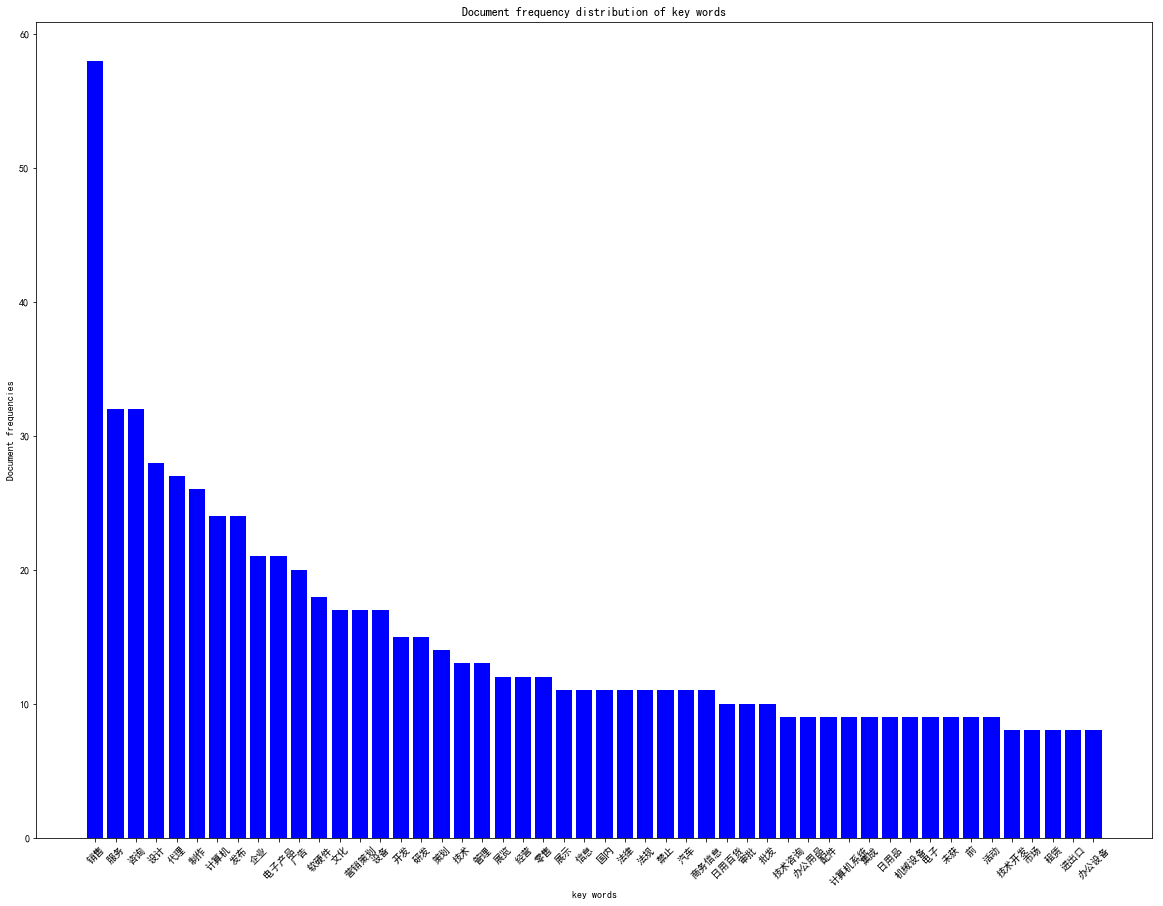

In [330]:
plot_frequency_distribution(dictionary)

**结论：** 从图中可以看出，关键词的文档频度呈明显的下降趋势，排名前20的关键词中除`销售`、`服务`等一般用词外，含有`咨询`、`设计`、`制作`、`计算机`、`电子产品`、`软硬件`、`营销策划`、`开发`、`策划`等关键词，并且频度基本在20以上。从这些关键词中可大体推断出这100家企业的产品信息的共性，即应该是计算机科技信息类企业，提供软硬件开发、设计、制作及营销策划、咨询等销售和服务。因此这些企业的产品信息共性较强，可以考虑定义为参与推荐计算的字段，并且定义较高的权重。

### 对未成交数据的分析

In [323]:
%time corpus = nodeals.products.apply(tokenize, args=(stopwords,))
dictionary = corpora.Dictionary(corpus)

CPU times: user 57.3 ms, sys: 0 ns, total: 57.3 ms
Wall time: 57.3 ms


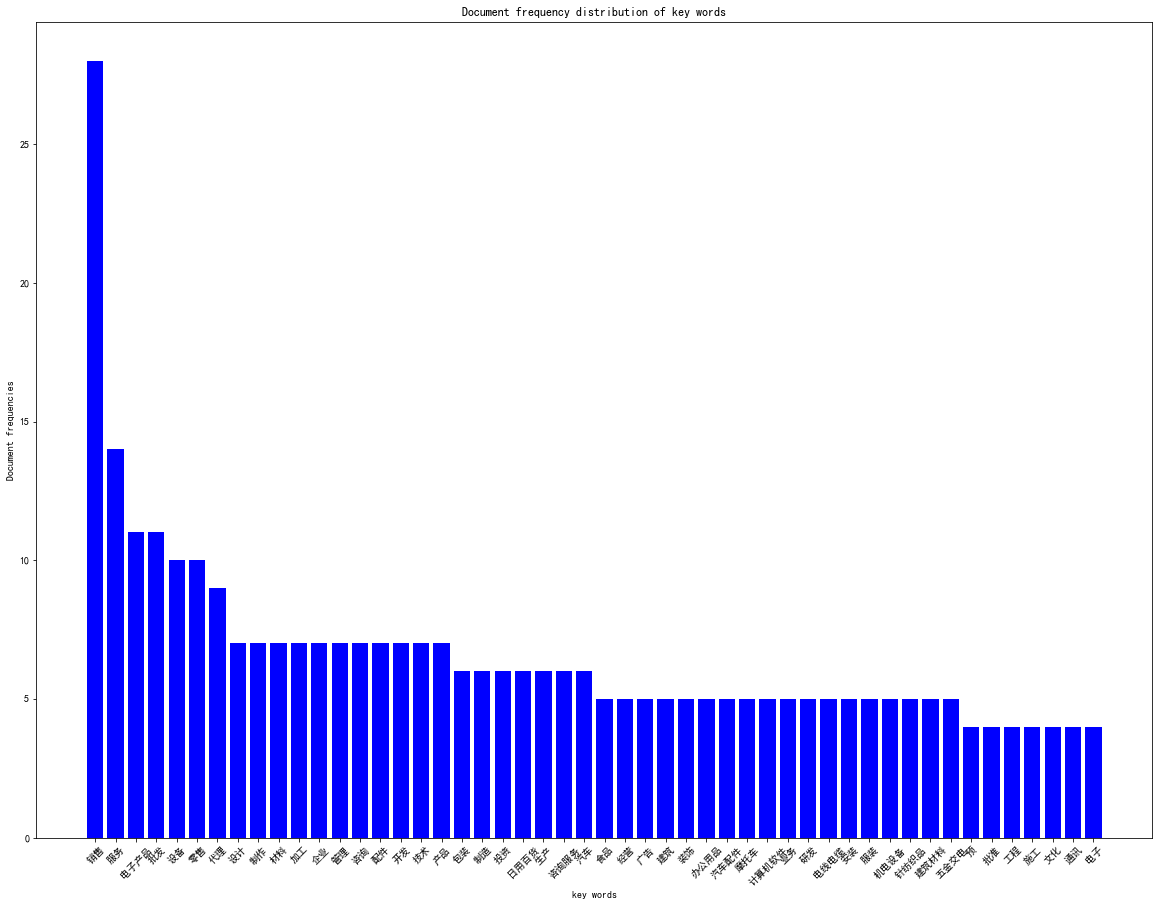

In [326]:
plot_frequency_distribution(dictionary)

**结论：** 从图中可以看出，除开`销售`、`服务`的一般用词外，关键词的文档频度整体不高（在12以下，大部分在8以下），且分布比较平均，没有明显的趋势。与上面推荐企业的产品信息对比来看，从这些关键词中不能找到这100家企业产品信息的共性，即使`电子产品`、`批发`、`设备`、`零售`、`代理`等关键词的频度稍高于其他关键词（10左右），但是也并无明显优势。因此这些企业的产品信息共性较弱，可以考虑不定义为参与推荐计算的字段，或者定义较低的权重。

### 思考

上面我们仅考虑了关键词的文档频度，可能会存在近义词，比如`开发`和`研发`等，如果考虑合并近义词的频度，关键词意思相近的词的频度将会提高，对我们共性分析会造成影响。

## 总结

我们在上面的演示中以三类典型的字段展示了分析数据共性的整个过程。从分析过程中，我们可以看到这类分析没有固定模式，要根据数据性质和面向业务的不同采取不同的方法。因此，就像我们在需求描述一节所说，重点不是掌握具体的方法，而是掌握数据分析的思想，所谓“兵无常势，水无常形”，根据需要随时变换分析方法，并从数据、业务多角度进行分析，这样才能挖掘出数据中隐含的信息。